/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/tmp/ipython-input-1447877710.py:64: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_lags.f

All historical data metrics:
R²: 0.907 | MAE: 3948132.656 | RMSE: 8807450.776

Test period metrics:
R²: 0.531 | MAE: 15624026.000 | RMSE: 19366394.795


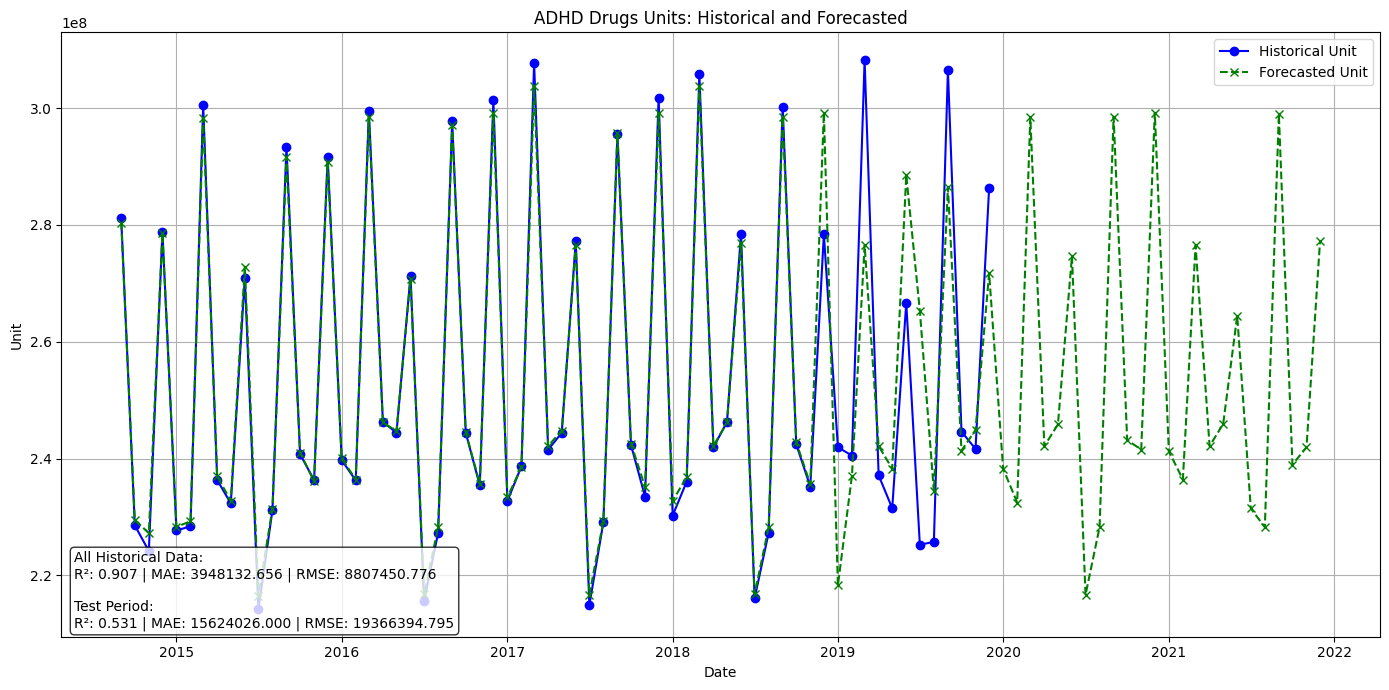

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
from xgboost import XGBRegressor
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from math import sqrt

# Data cleaning
df = pd.read_csv('ADHD2019.csv')  # Must contain: date + price/sales + features
df['date'] = pd.to_datetime(df['Year_Month'], format='%Y_%m')
df = df[df['Unit'] > 0]
df = df.sort_values('date')
df = df.drop(['Year_Month', 'Month', 'Year'], axis=1)
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year

# --- ADD LAGGED FEATURES ONLY FOR UNIT ---
max_lag = 2
for lag in range(1, max_lag + 1):
    df[f'Unit_lag{lag}'] = df['Unit'].shift(lag)

df.dropna(inplace=True)

# Define features and target
feature_cols = [f'Unit_lag{lag}' for lag in range(1, max_lag + 1)] + ['month', 'year']
X = df[feature_cols]
y = df['Unit']

# Train/test split
split_idx = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
dates_train, dates_test = df['date'].iloc[:split_idx], df['date'].iloc[split_idx:]

# Train model
model = XGBRegressor(n_estimators=40, learning_rate=0.1, random_state=42)
model.fit(X_train, y_train)

# Predict
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

# Forecast future lag features with Holt-Winters until Dec 2021
last_date = df['date'].max()
forecast_end = pd.Timestamp('2021-12-01')
forecast_horizon = ((forecast_end.year - last_date.year) * 12 + (forecast_end.month - last_date.month))

future_dates = pd.date_range(start=last_date + pd.offsets.MonthBegin(1), periods=forecast_horizon, freq='MS')
future_lags = pd.DataFrame({'date': future_dates})

for col in feature_cols:
    series = df.set_index('date')[col]
    try:
        hw_model = ExponentialSmoothing(series, trend='add', seasonal='add', seasonal_periods=12)
        hw_fit = hw_model.fit()
        forecast_vals = hw_fit.forecast(forecast_horizon)
        future_lags[col] = forecast_vals.values
    except Exception as e:
        print(f"HW forecast failed for {col}: {e}")
        future_lags[col] = np.nan

future_lags.fillna(method='ffill', inplace=True)
future_lags.fillna(method='bfill', inplace=True)

# Predict future Unit
X_future = future_lags[feature_cols]
future_lags['Unit_predicted'] = model.predict(X_future)

# Combine predictions
historical_preds = pd.DataFrame({
    'date': df['date'],
    'Unit_actual': df['Unit'],
    'Unit_predicted': np.nan
})
historical_preds.loc[X_train.index, 'Unit_predicted'] = train_pred
historical_preds.loc[X_test.index, 'Unit_predicted'] = test_pred

forecasted_preds = future_lags[['date', 'Unit_predicted']].copy()
forecasted_preds['Unit_actual'] = np.nan

all_preds = pd.concat([historical_preds, forecasted_preds], ignore_index=True)

# Metrics
r2_all = r2_score(y, historical_preds.loc[~historical_preds['Unit_predicted'].isna(), 'Unit_predicted'])
mae_all = mean_absolute_error(y, historical_preds.loc[~historical_preds['Unit_predicted'].isna(), 'Unit_predicted'])
rmse_all = sqrt(mean_squared_error(y, historical_preds.loc[~historical_preds['Unit_predicted'].isna(), 'Unit_predicted']))

r2_test = r2_score(y_test, test_pred)
mae_test = mean_absolute_error(y_test, test_pred)
rmse_test = sqrt(mean_squared_error(y_test, test_pred))

print(f"All historical data metrics:")
print(f"R²: {r2_all:.3f} | MAE: {mae_all:.3f} | RMSE: {rmse_all:.3f}")
print(f"\nTest period metrics:")
print(f"R²: {r2_test:.3f} | MAE: {mae_test:.3f} | RMSE: {rmse_test:.3f}")

# Plot
plt.figure(figsize=(14, 7))
plt.plot(all_preds['date'], all_preds['Unit_actual'], label='Historical Unit', color='blue', marker='o')
plt.plot(all_preds['date'], all_preds['Unit_predicted'], label='Forecasted Unit', linestyle='--', marker='x', color='green')
plt.title('ADHD Drugs Units: Historical and Forecasted')
plt.xlabel('Date')
plt.ylabel('Unit')
plt.legend()
plt.grid(True)

metrics_text = (
    f'All Historical Data:\n'
    f'R²: {r2_all:.3f} | MAE: {mae_all:.3f} | RMSE: {rmse_all:.3f}\n\n'
    f'Test Period:\n'
    f'R²: {r2_test:.3f} | MAE: {mae_test:.3f} | RMSE: {rmse_test:.3f}'
)
plt.text(0.01, 0.01, metrics_text, transform=plt.gca().transAxes,
         fontsize=10, verticalalignment='bottom',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
plt.tight_layout()
plt.show()

# Save to CSV
all_preds.to_csv('unit_predictions_ADHDlag2.csv', index=False)